In [2]:
import numpy as np
import pandas as pd
import os, time, glob, sys
import matplotlib.pyplot as plt
from collections import Counter
import mne

# Read raw data

In [95]:
# import EEG data
raw = mne.io.read_raw_brainvision("") # read .vhdr file

# data = raw.get_data()

events, event_types = mne.events_from_annotations(raw)
print(events)
print(event_types)

Extracting parameters from C:/Users/USER/Desktop/융복합과제/Data/EEG/lsy_240528.vhdr...
Setting channel info structure...
Used Annotations descriptions: ['New Segment/', 'stimulus/Task end', 'stimulus/Task start', 'stimulus/c', 'stimulus/i', 'stimulus/n', 'stimulus/start anger', 'stimulus/start fear', 'stimulus/start irritation', 'stimulus/start joy', 'stimulus/start pride', 'stimulus/start relief', 'stimulus/start sad', 'stimulus/start tender']
[[     0      0  99999]
 [ 13995      0  10002]
 [ 14245      0  10011]
 [ 15960      0  10004]
 [ 16400      0  10010]
 [ 18395      0  10004]
 [ 18830      0  10007]
 [ 19980      0  10004]
 [ 20440      0  10008]
 [ 21420      0  10003]
 [ 21830      0  10010]
 [ 23280      0  10004]
 [ 23695      0  10009]
 [ 24565      0  10003]
 [ 24795      0  10001]
 [ 25025      0  10009]
 [ 26560      0  10007]
 [ 27430      0  10003]
 [ 27870      0  10006]
 [ 28635      0  10003]
 [ 29125      0  10008]
 [ 30375      0  10005]
 [ 30735      0  10012]
 [ 

C:\Users\USER\AppData\Local\Temp\ipykernel_25104\1518100894.py:2: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision("C:/Users/USER/Desktop/융복합과제/Data/EEG/lsy_240528.vhdr")


In [73]:
# raw channel indices
channel_indices = {ch_name: idx for idx, ch_name in enumerate(raw.info['ch_names'])}

ch_name_re_ref = []
ch_idx_re_ref = []
for ch_name, idx in channel_indices.items():
    print(f"ch name: {ch_name}\tindex: {idx}")
    ch_name_re_ref.append(ch_name)
    ch_idx_re_ref.append(idx)

ch name: Fp1	index: 0
ch name: Fz	index: 1
ch name: F3	index: 2
ch name: F7	index: 3
ch name: FT9	index: 4
ch name: FC5	index: 5
ch name: FC1	index: 6
ch name: C3	index: 7
ch name: T7	index: 8
ch name: TP9	index: 9
ch name: CP5	index: 10
ch name: CP1	index: 11
ch name: Pz	index: 12
ch name: P3	index: 13
ch name: P7	index: 14
ch name: Oz	index: 15
ch name: O2	index: 16
ch name: P4	index: 17
ch name: P8	index: 18
ch name: TP10	index: 19
ch name: CP6	index: 20
ch name: CP2	index: 21
ch name: Cz	index: 22
ch name: C4	index: 23
ch name: T8	index: 24
ch name: FT10	index: 25
ch name: FC6	index: 26
ch name: FC2	index: 27
ch name: F4	index: 28
ch name: F8	index: 29
ch name: Fp2	index: 30


# Re-referening (If necessary)

Location for this channel is unknown; consider calling set_montage() after adding new reference channels if needed. Applying a montage will only set locations of channels that exist at the time it is applied.


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
31


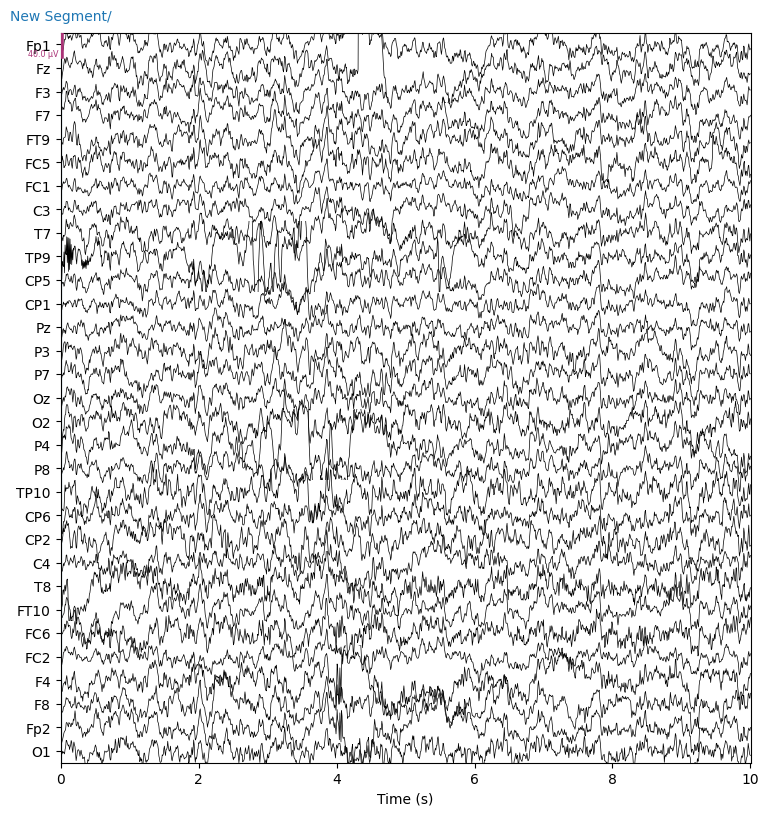

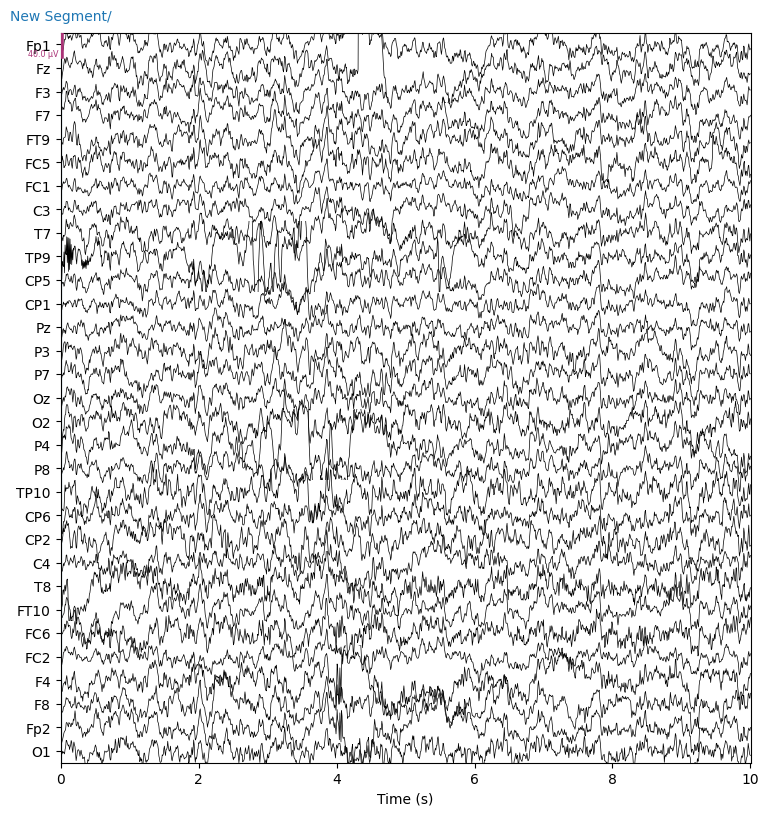

In [142]:
# Re-referencing the data
load_raw = raw.load_data()

add_ref = mne.add_reference_channels(load_raw, ref_channels=['O1']) # raw reference channel: O1
reref_raw, reref_arr = mne.set_eeg_reference(add_ref, ref_channels=['Cz']) # set re-reference channel: Cz
reref_data = mne.io.Raw.drop_channels(reref_raw, ['Cz']) # drop raw reference channel: O1

montage = mne.channels.make_standard_montage('standard_1005')
reref_data.set_montage(montage)

print(len(reref_data.ch_names))
reref_data.plot(n_channels=len(reref_data.ch_names), show_scrollbars=False)
plt.close()

In [143]:
# re-reference channel indices
channel_indices = {ch_name: idx for idx, ch_name in enumerate(reref_data.info['ch_names'])}

ch_name_re_ref = []
ch_idx_re_ref = []
for ch_name, idx in channel_indices.items():
    print(f"ch name: {ch_name}\tindex: {idx}")
    ch_name_re_ref.append(ch_name)
    ch_idx_re_ref.append(idx)

ch name: Fp1	index: 0
ch name: Fz	index: 1
ch name: F3	index: 2
ch name: F7	index: 3
ch name: FT9	index: 4
ch name: FC5	index: 5
ch name: FC1	index: 6
ch name: C3	index: 7
ch name: T7	index: 8
ch name: TP9	index: 9
ch name: CP5	index: 10
ch name: CP1	index: 11
ch name: Pz	index: 12
ch name: P3	index: 13
ch name: P7	index: 14
ch name: Oz	index: 15
ch name: O2	index: 16
ch name: P4	index: 17
ch name: P8	index: 18
ch name: TP10	index: 19
ch name: CP6	index: 20
ch name: CP2	index: 21
ch name: C4	index: 22
ch name: T8	index: 23
ch name: FT10	index: 24
ch name: FC6	index: 25
ch name: FC2	index: 26
ch name: F4	index: 27
ch name: F8	index: 28
ch name: Fp2	index: 29
ch name: O1	index: 30


# Preprocessing

1. Band-pass filtering

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 40.00 Hz: -6.02, -6.02 dB



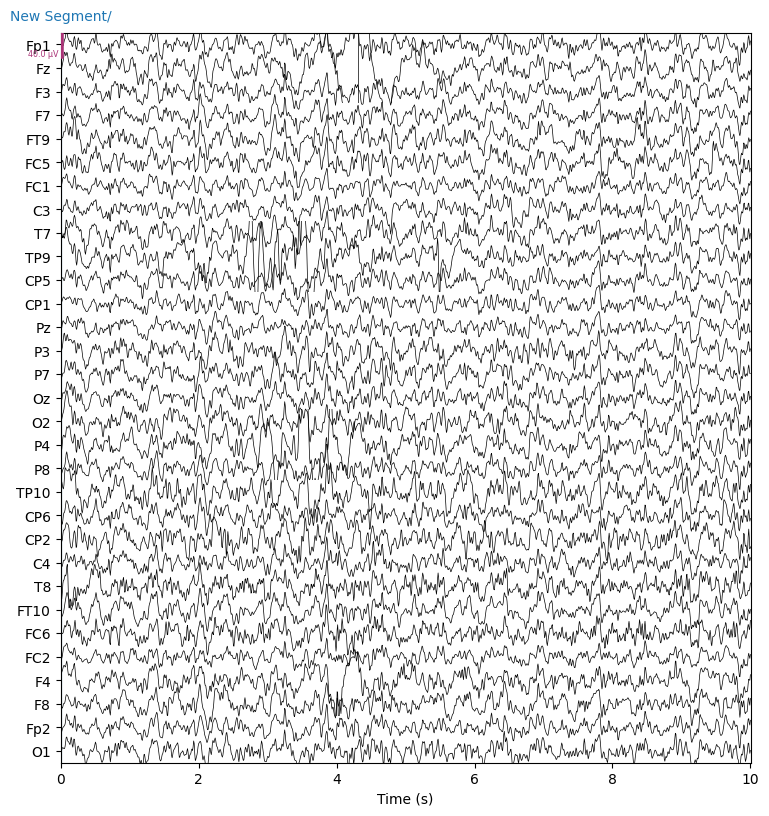

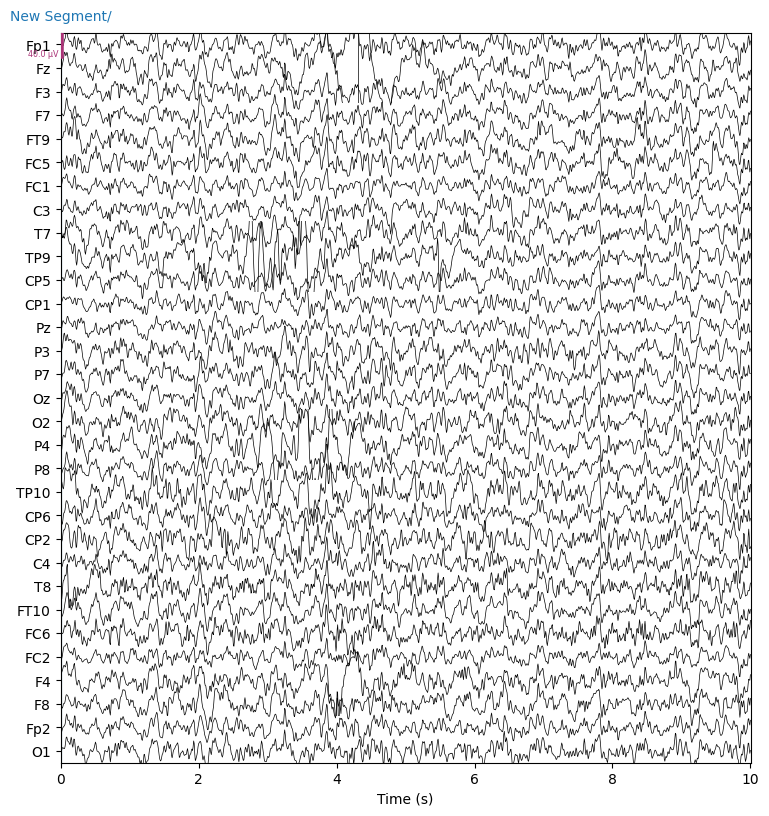

In [203]:
# data = raw.load_data() # if you did Re-referencing(the above codes), you don't need this code
# filtered_data = data.filter(l_freq=0.5, h_freq=40, method='iir') # for raw data
filtered_data = reref_data.filter(l_freq=1, h_freq=40, method='iir') # for Re-ferencing data

filtered_data.plot(n_channels=len(filtered_data.ch_names), show_scrollbars=False)

2. ICA

In [205]:
ica = mne.preprocessing.ICA(method="infomax", random_state=1) # we used "infomax" algorithm in EEGLAB
ica.fit(filtered_data)

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 30 components
Computing Infomax ICA
Fitting ICA took 23.6s.


<ICA | raw data decomposition, method: infomax (fit in 184 iterations on 161730 samples), 30 ICA components (31 PCA components available), channel types: eeg, no sources marked for exclusion>

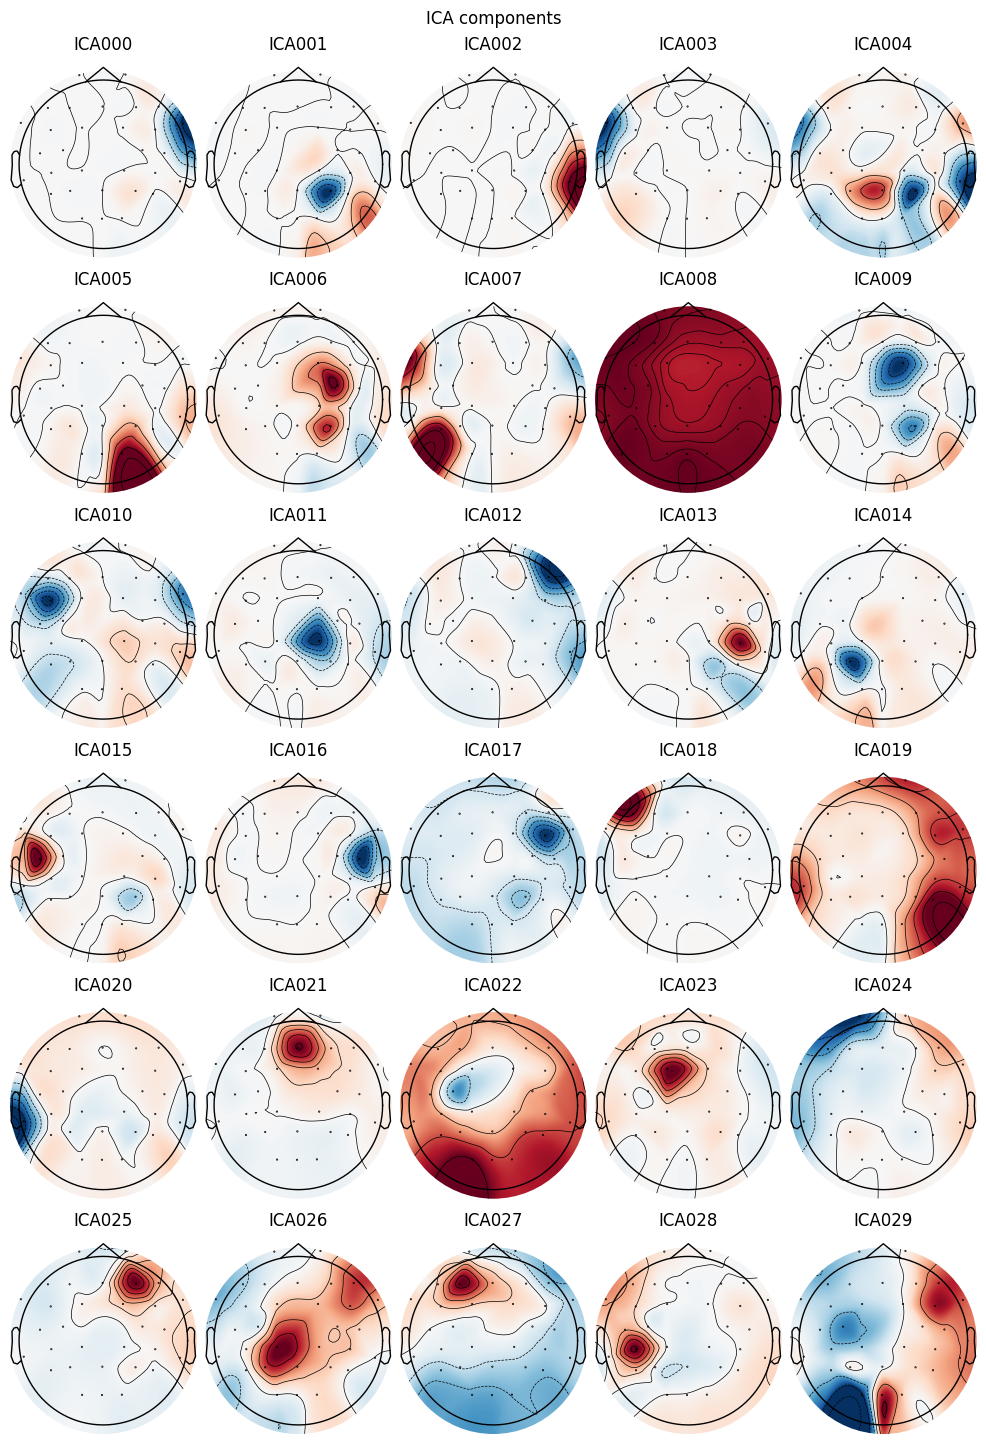

In [206]:
ica.plot_components(inst=filtered_data, picks=range(len(filtered_data.ch_names)))
plt.close()

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
323 matching events found
No baseline correction applied
0 projection items activated


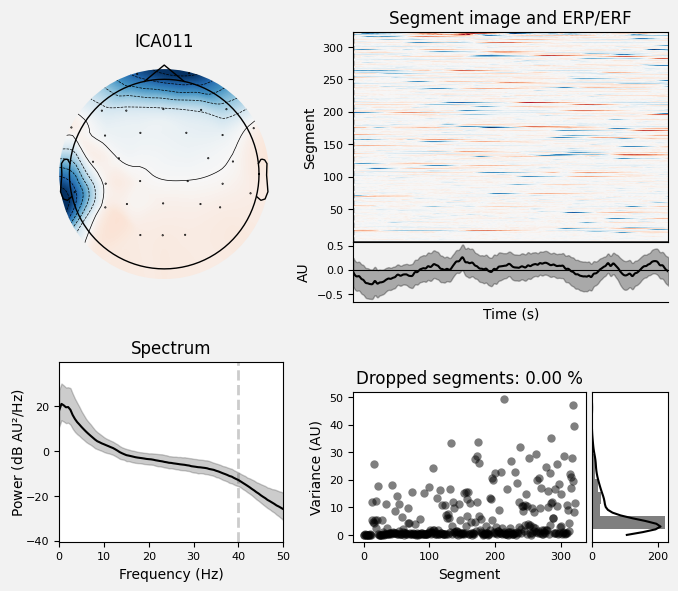

[<Figure size 700x600 with 6 Axes>]

In [194]:
ica.plot_properties(filtered_data, picks=11) #picks range: 0~len(filtered_data.ch_names)

Creating RawArray with float64 data, n_channels=31, n_times=161730
    Range : 0 ... 161729 =      0.000 ...   646.916 secs
Ready.


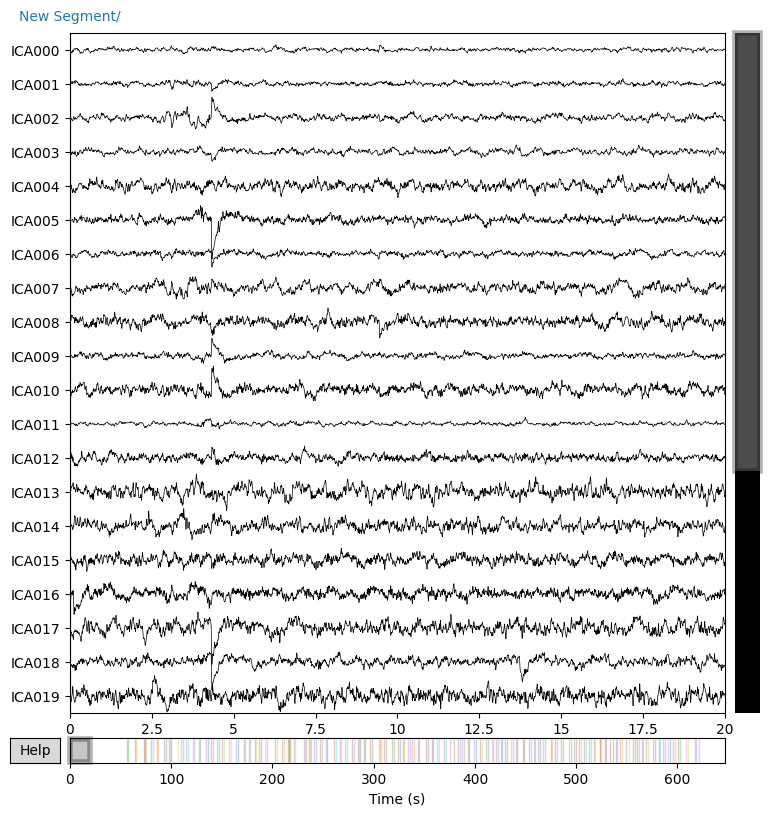

In [188]:
ica.plot_sources(inst=filtered_data)
plt.close()

In [195]:
ica.exclude = [11]

In [196]:
ica.apply(filtered_data)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 1 ICA component
    Projecting back using 31 PCA components


<RawBrainVision | lsy_240528.eeg, 31 x 161730 (646.9 s), ~38.3 MB, data loaded>

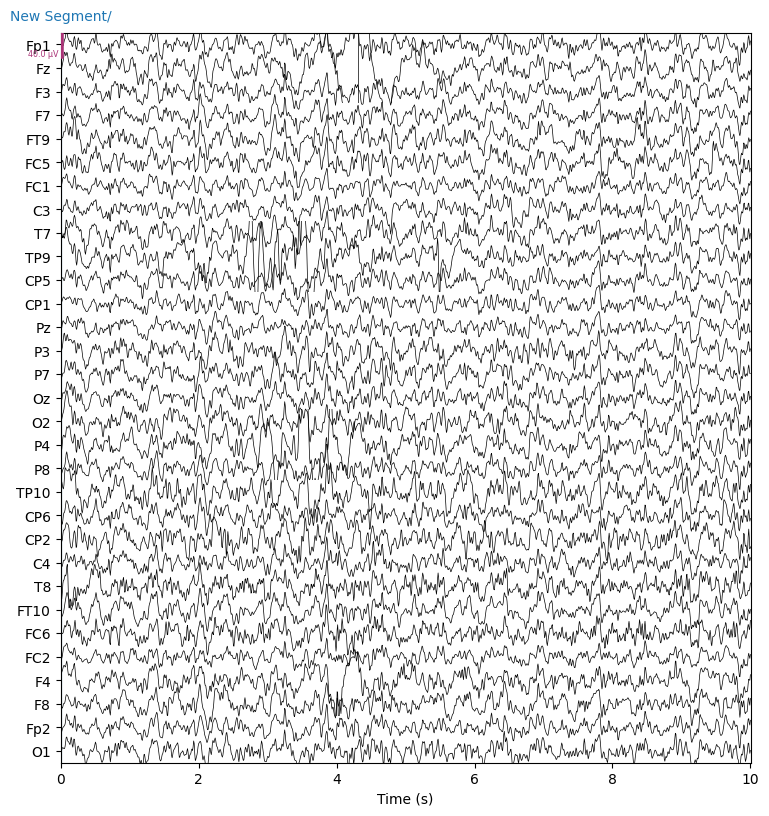

In [208]:
filtered_data.plot(n_channels=len(filtered_data.ch_names), show_scrollbars=False)
plt.close()

3. Extract epochs

In [222]:
event, event_types = mne.events_from_annotations(filtered_data)

print(event_types)
# print(event)

Used Annotations descriptions: ['New Segment/', 'stimulus/Task end', 'stimulus/Task start', 'stimulus/c', 'stimulus/i', 'stimulus/n', 'stimulus/start anger', 'stimulus/start fear', 'stimulus/start irritation', 'stimulus/start joy', 'stimulus/start pride', 'stimulus/start relief', 'stimulus/start sad', 'stimulus/start tender']
{'New Segment/': 99999, 'stimulus/Task end': 10001, 'stimulus/Task start': 10002, 'stimulus/c': 10003, 'stimulus/i': 10004, 'stimulus/n': 10005, 'stimulus/start anger': 10006, 'stimulus/start fear': 10007, 'stimulus/start irritation': 10008, 'stimulus/start joy': 10009, 'stimulus/start pride': 10010, 'stimulus/start relief': 10011, 'stimulus/start sad': 10012, 'stimulus/start tender': 10013}


In [232]:
# Setting event types for epoch extraction
correct, incorrect, neutral = 10003, 10004, 10005

In [345]:
# picks: Channels to indclue. Default is None(all channels).
correct_epochs = mne.Epochs(filtered_data, events, event_id=correct, tmin=-0.2, tmax=1, proj=True, picks=None, baseline=[-0.2, 0])
incorrect_epochs = mne.Epochs(filtered_data, events, event_id=incorrect, tmin=-0.2, tmax=1, proj=True, picks=None, baseline=[-0.2, 0])
neutral_epochs = mne.Epochs(filtered_data, events, event_id=neutral, tmin=-0.2, tmax=1, proj=True, picks=None, baseline=[-0.2, 0])

Not setting metadata
35 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
53 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
7 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated


In [346]:
# concatenate epochs
incorr_epochs = mne.concatenate_epochs([incorrect_epochs, neutral_epochs])

Using data from preloaded Raw for 53 events and 301 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 7 events and 301 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 53 events and 301 original time points ...
Using data from preloaded Raw for 7 events and 301 original time points ...
Not setting metadata
60 matching events found
Applying baseline correction (mode: mean)


C:\Users\USER\AppData\Local\Temp\ipykernel_25104\81185391.py:1: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  incorr_epochs = mne.concatenate_epochs([incorrect_epochs, neutral_epochs])


# Plotting

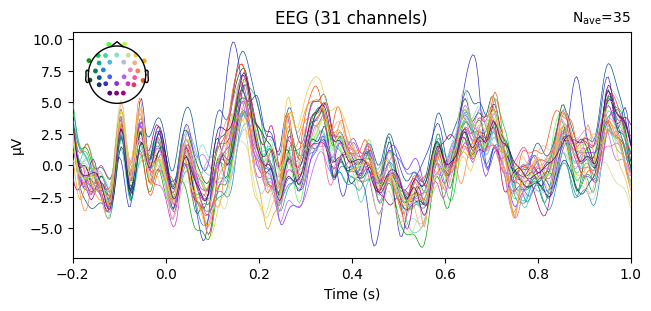

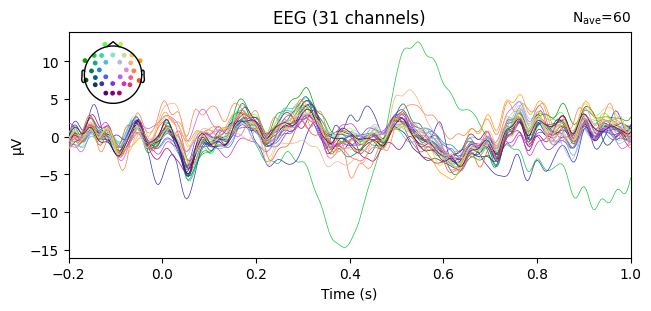

In [347]:
# Average epochs: all channels
avg_corr = correct_epochs.average()
avg_incorr = incorr_epochs.average()

fig = avg_corr.plot()
fig = avg_incorr.plot()

Need more than one channel to make topography for eeg. Disabling interactivity.


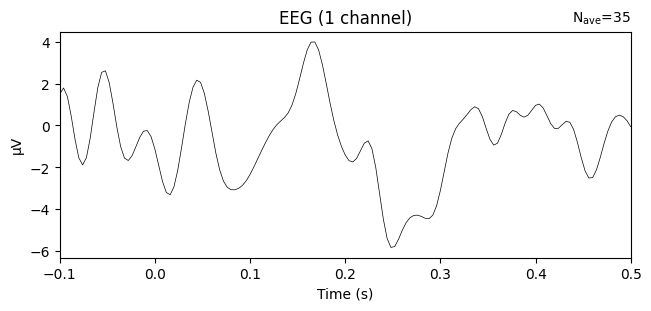

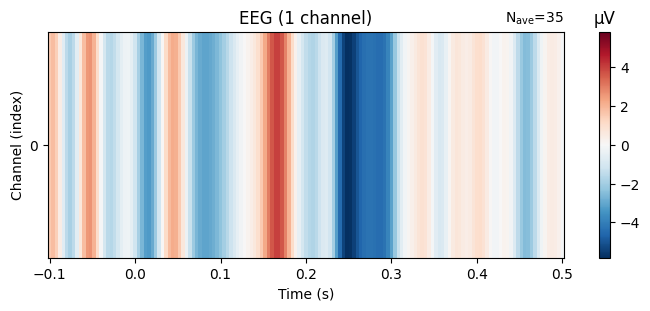

In [328]:
pick_ch_corr = avg_corr.pick('Pz')

pick_ch_corr.plot()
pick_ch_corr.plot_image()
plt.close()
# pick_ch_corr.compute_psd().plot()

Need more than one channel to make topography for eeg. Disabling interactivity.


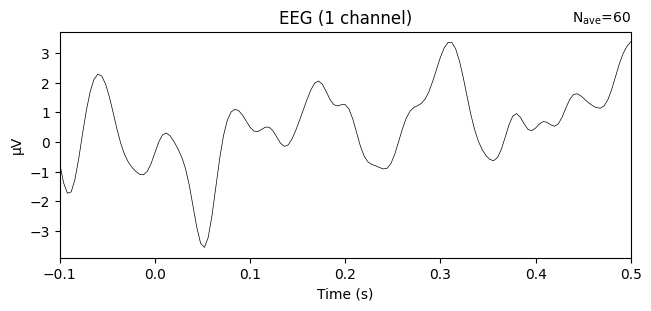

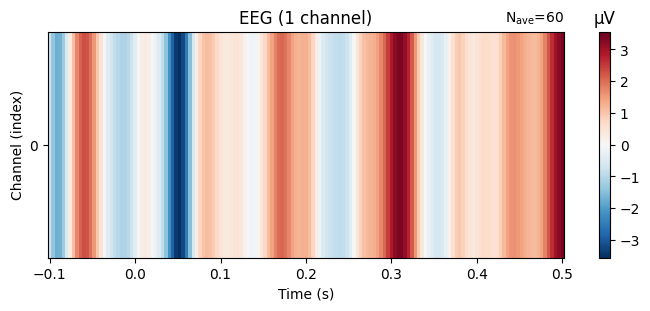

In [329]:
pick_ch_incorr = avg_incorr.pick('Pz')

pick_ch_incorr.plot()
pick_ch_incorr.plot_image()
plt.close()
# pick_ch_incorr.compute_psd().plot()

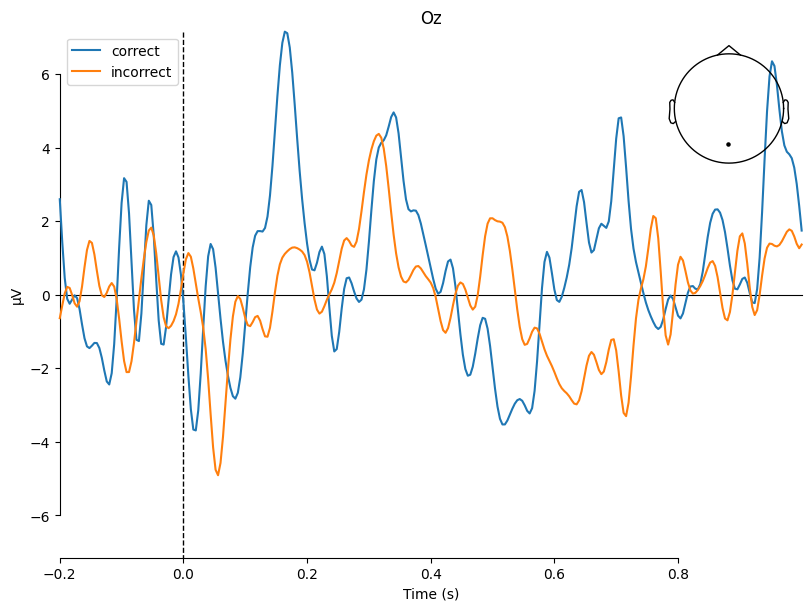

[<Figure size 800x600 with 2 Axes>]

In [354]:
avg_corr = correct_epochs.average()
avg_incorr = incorr_epochs.average()

plot_dict = {'correct': avg_corr.pick('Oz'), 'incorrect': avg_incorr.pick('Oz')}
mne.viz.plot_compare_evokeds(plot_dict, picks=range(len(pick_ch_corr.ch_names)))